In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.losses import mean_squared_logarithmic_error
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers
from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import set_config; set_config(display='diagram')

import matplotlib.pyplot as plt
import seaborn as sns

import re


In [2]:
train_data = pd.read_parquet(
    path='../models/train_data_from_pipeline_lgbm.parquet'
)

In [3]:
train_data.columns

Index(['sales_lag_1', 'sales_lag_2', 'sales_lag_7', 'sales_lag_28',
       'sales_mean_28_14', 'sales_mean_28_7', 'sales_mean_7_30',
       'sales_mean_28_30', 'sales_mean_7_14', 'sales_mean_7_7',
       'sales_mean_1_30', 'sales_mean_1_14', 'sales_mean_1_7',
       'sales_std_7_14', 'sales_std_1_30', 'sales_std_7_30', 'sales_std_1_14',
       'sales_std_28_7', 'sales_std_1_7', 'sales_std_28_14', 'sales_std_7_7',
       'sales_std_28_30', 'transactions_lag_1',
       'time_since_2013-01-01 00:00:00', 'year', 'quarter_of_year',
       'month_of_year', 'week_of_year', 'week_of_month', 'day_of_month',
       'day_of_week', 'is_weekend', 'onpromotion', 'oil_price_interpolated',
       'enc_family_mean', 'enc_store_nbr_mean', 'enc_city_mean',
       'enc_state_mean', 'enc_type_mean', 'enc_cluster_mean', 'store_nbr',
       'family', 'sales', 'transactions', 'is_Local_holiday',
       'is_Regional_holiday', 'is_National_holiday', 'wage_day',
       'earthquake_day', 'earthquake_impact'],
   

In [4]:
def reduce_memory_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
# Reduce size of train_data to fit the model 
train_data = reduce_memory_usage(train_data)
train_data.columns

Mem. usage decreased to 280.62 Mb (68.2% reduction)


Index(['sales_lag_1', 'sales_lag_2', 'sales_lag_7', 'sales_lag_28',
       'sales_mean_28_14', 'sales_mean_28_7', 'sales_mean_7_30',
       'sales_mean_28_30', 'sales_mean_7_14', 'sales_mean_7_7',
       'sales_mean_1_30', 'sales_mean_1_14', 'sales_mean_1_7',
       'sales_std_7_14', 'sales_std_1_30', 'sales_std_7_30', 'sales_std_1_14',
       'sales_std_28_7', 'sales_std_1_7', 'sales_std_28_14', 'sales_std_7_7',
       'sales_std_28_30', 'transactions_lag_1',
       'time_since_2013-01-01 00:00:00', 'year', 'quarter_of_year',
       'month_of_year', 'week_of_year', 'week_of_month', 'day_of_month',
       'day_of_week', 'is_weekend', 'onpromotion', 'oil_price_interpolated',
       'enc_family_mean', 'enc_store_nbr_mean', 'enc_city_mean',
       'enc_state_mean', 'enc_type_mean', 'enc_cluster_mean', 'store_nbr',
       'family', 'sales', 'transactions', 'is_Local_holiday',
       'is_Regional_holiday', 'is_National_holiday', 'wage_day',
       'earthquake_day', 'earthquake_impact'],
   

In [6]:
columns_to_drop = ['sales_lag_1', 'sales_lag_2', 'sales_lag_7', 'sales_lag_28',
       'sales_mean_28_14', 'sales_mean_28_7', 'sales_mean_7_30',
       'sales_mean_28_30', 'sales_mean_7_14', 'sales_mean_7_7',
       'sales_mean_1_30', 'sales_mean_1_14', 'sales_mean_1_7',
       'sales_std_7_14', 'sales_std_1_30', 'sales_std_7_30', 'sales_std_1_14',
       'sales_std_28_7', 'sales_std_1_7', 'sales_std_28_14', 'sales_std_7_7',
       'sales_std_28_30', 'transactions_lag_1',
       'time_since_2013-01-01 00:00:00']
train_data = train_data.drop(columns_to_drop, axis=1)

In [8]:
train_data = train_data.dropna()

In [9]:
train_data

year  quarter_of_year  month_of_year  week_of_year  \
id            date                                                             
10_AUTOMOTIVE 2013-01-02   0.0         0.000000        0.00000      0.000000   
              2013-01-03   0.0         0.000000        0.00000      0.000000   
              2013-01-04   0.0         0.000000        0.00000      0.000000   
              2013-01-05   0.0         0.000000        0.00000      0.000000   
              2013-01-06   0.0         0.000000        0.00000      0.000000   
...                        ...              ...            ...           ...   
9_SEAFOOD     2017-08-11   1.0         0.666504        0.63623      0.596191   
              2017-08-12   1.0         0.666504        0.63623      0.596191   
              2017-08-13   1.0         0.666504        0.63623      0.596191   
              2017-08-14   1.0         0.666504        0.63623      0.615234   
              2017-08-15   1.0         0.666504        0.63623      0.615234   

                          week_of_month  day_of_month  day_of_week  \
id            date                                                   
10_AUTOMOTIVE 2013-01-02           0.00      0.033325     0.333252   
              2013-01-03           0.00      0.066650     0.500000   
              2013-01-04           0.00      0.099976     0.666504   
              2013-01-05           0.00      0.133301     0.833496   
              2013-01-06           0.00      0.166626     1.000000   
...                                 ...           ...          ...   
9_SEAFOOD     2017-08-11           0.25      0.333252     0.666504   
              2017-08-12           0.25      0.366699     0.833496   
              2017-08-13           0.25      0.399902     1.000000   
              2017-08-14           0.25      0.433350     0.000000   
              2017-08-15           0.50      0.466553     0.166626   

                          is_weekend  onpromotion  oil_price_interpolated  \
id            date                                                          
10_AUTOMOTIVE 2013-01-02         0.0     0.000000                0.792969   
              2013-01-03         0.0     0.000000                0.791016   
              2013-01-04         0.0     0.000000                0.792969   
              2013-01-05         1.0     0.000000                0.792969   
              2013-01-06         1.0     0.000000                0.792969   
...                              ...          ...                     ...   
9_SEAFOOD     2017-08-11         0.0     0.000000                0.267822   
              2017-08-12         1.0     0.005398                0.260742   
              2017-08-13         1.0     0.000000                0.253418   
              2017-08-14         0.0     0.000000                0.253418   
              2017-08-15         0.0     0.000000                0.253174   

                          ...  store_nbr      family      sales  transactions  \
id            date        ...                                                   
10_AUTOMOTIVE 2013-01-02  ...         10  AUTOMOTIVE   3.000000        1293.0   
              2013-01-03  ...         10  AUTOMOTIVE   2.000000        1157.0   
              2013-01-04  ...         10  AUTOMOTIVE   2.000000         970.0   
              2013-01-05  ...         10  AUTOMOTIVE   0.000000        1269.0   
              2013-01-06  ...         10  AUTOMOTIVE   0.000000        1173.0   
...                       ...        ...         ...        ...           ...   
9_SEAFOOD     2017-08-11  ...          9     SEAFOOD  23.830999        1848.0   
              2017-08-12  ...          9     SEAFOOD  16.859001        1920.0   
              2017-08-13  ...          9     SEAFOOD  20.000000        1745.0   
              2017-08-14  ...          9     SEAFOOD  17.000000        1971.0   
              2017-08-15  ...          9     SEAFOOD  16.000000        2156.0   

                  

In [10]:
X = train_data.drop(columns=['sales', 'store_nbr', 'family', 'transactions'])
X = X.query("date >= '2013-02-27'")    # Start date of X_train = "2013-02-27" (exclude NaN rows after creating lag + window features)
X = X.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "_", x))

y = train_data[["sales"]].query("date >= '2013-02-27'")


In [11]:
# Check correlation between "onpromotion" and "sales"
X['onpromotion'].corr(y['sales'])

0.4298437115478731

cat: 'day_of_week_str'
numeric: store_nbr,sales,onpromotion,wage_day,

In [15]:
cat_cols = X.select_dtypes("category").columns.tolist()
cat_cols

['is_Local_holiday',
 'is_Regional_holiday',
 'is_National_holiday',
 'wage_day',
 'earthquake_day',
 'earthquake_impact']

In [16]:

columns_to_encode = ['is_Local_holiday', 'is_Regional_holiday', 'is_National_holiday', 'wage_day', 'earthquake_day', 'earthquake_impact']

# Create an instance of LabelEncoder
encoder = LabelEncoder()

# Loop through each column and label encode its values
for column in columns_to_encode:
    encoded_values = encoder.fit_transform(X[column])
    X[column] = encoded_values

In [17]:
X

year  quarter_of_year  month_of_year  week_of_year  \
id            date                                                             
10_AUTOMOTIVE 2013-02-27   0.0         0.000000       0.090881      0.153809   
              2013-02-28   0.0         0.000000       0.090881      0.153809   
              2013-03-01   0.0         0.000000       0.181763      0.153809   
              2013-03-02   0.0         0.000000       0.181763      0.153809   
              2013-03-03   0.0         0.000000       0.181763      0.153809   
...                        ...              ...            ...           ...   
9_SEAFOOD     2017-08-11   1.0         0.666504       0.636230      0.596191   
              2017-08-12   1.0         0.666504       0.636230      0.596191   
              2017-08-13   1.0         0.666504       0.636230      0.596191   
              2017-08-14   1.0         0.666504       0.636230      0.615234   
              2017-08-15   1.0         0.666504       0.636230      0.615234   

                          week_of_month  day_of_month  day_of_week  \
id            date                                                   
10_AUTOMOTIVE 2013-02-27           0.75      0.866699     0.333252   
              2013-02-28           0.75      0.899902     0.500000   
              2013-03-01           0.00      0.000000     0.666504   
              2013-03-02           0.00      0.033325     0.833496   
              2013-03-03           0.00      0.066650     1.000000   
...                                 ...           ...          ...   
9_SEAFOOD     2017-08-11           0.25      0.333252     0.666504   
              2017-08-12           0.25      0.366699     0.833496   
              2017-08-13           0.25      0.399902     1.000000   
              2017-08-14           0.25      0.433350     0.000000   
              2017-08-15           0.50      0.466553     0.166626   

                          is_weekend  onpromotion  oil_price_interpolated  \
id            date                                                          
10_AUTOMOTIVE 2013-02-27         0.0     0.000000                0.789551   
              2013-02-28         0.0     0.000000                0.779785   
              2013-03-01         0.0     0.000000                0.764160   
              2013-03-02         1.0     0.000000                0.764160   
              2013-03-03         1.0     0.000000                0.760742   
...                              ...          ...                     ...   
9_SEAFOOD     2017-08-11         0.0     0.000000                0.267822   
              2017-08-12         1.0     0.005398                0.260742   
              2017-08-13         1.0     0.000000                0.253418   
              2017-08-14         0.0     0.000000                0.253418   
              2017-08-15         0.0     0.000000                0.253174   

                          ...  enc_city_mean  enc_state_mean  enc_type_mean  \
id            date        ...                                                 
10_AUTOMOTIVE 2013-02-27  ...       0.002268        0.003124       0.001215   
              2013-02-28  ...       0.002277        0.003136       0.001220   
              2013-03-01  ...       0.002300        0.003170       0.001233   
              2013-03-02  ...       0.002403        0.003309       0.001287   
              2013-03-03  ...       0.002424        0.003340       0.001299   
...                       ...            ...             ...            ...   
9_SEAFOOD     2017-08-11  ...       0.517578        0.709961       0.162842   
              2017-08-12  ...       0.517578        0.709961       0.162842   
              2017-08-13  ...       0.517578        0.709961       0.162842   
              2017-08-14  ...       0.517578        0.709961       0.162842   
              2017-08-15  ...       0.517578        0.709961       0.162842   

                          enc_cluster_mean  

In [19]:
# split X_validation, y_validation to test and validation sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
X_train

,,year,quarter_of_year,month_of_year,week_of_year,week_of_month,day_of_month,day_of_week,is_weekend,onpromotion,oil_price_interpolated,...,enc_city_mean,enc_state_mean,enc_type_mean,enc_cluster_mean,is_Local_holiday,is_Regional_holiday,is_National_holiday,wage_day,earthquake_day,earthquake_impact
id,date,,,,,,,,,,,,,,,,,,,,,
29_HOME CARE,2014-05-12,0.25,0.333252,0.363525,0.365479,0.25,0.366699,0.000000,0.0,0.000000,0.884766,...,0.271729,0.389160,0.151123,0.119202,1,1,1,0,0,0
2_SCHOOL AND OFFICE SUPPLIES,2014-10-21,0.25,1.000000,0.818359,0.807617,0.50,0.666504,0.166626,0.0,0.000000,0.675781,...,0.251465,0.390625,0.141113,0.163818,1,1,1,0,0,0
43_POULTRY,2015-08-07,0.50,0.666504,0.636230,0.596191,0.00,0.199951,0.666504,0.0,0.018890,0.209351,...,0.296143,0.407715,0.136230,0.128784,1,1,1,0,0,0
4_FROZEN FOODS,2016-01-18,0.75,0.000000,0.000000,0.038452,0.50,0.566895,0.000000,0.0,0.004047,0.028488,...,0.547363,0.747070,0.167480,0.130371,1,1,1,0,0,0
22_GROCERY I,2015-03-06,0.50,0.000000,0.181763,0.173096,0.00,0.166626,0.666504,0.0,0.000000,0.277344,...,0.078552,0.108215,0.104309,0.085632,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39_HOME APPLIANCES,2014-12-23,0.25,1.000000,1.000000,0.980957,0.75,0.733398,0.166626,0.0,0.000000,0.362305,...,0.399902,0.550781,0.158203,0.166626,1,1,0,0,0,0
4_PREPARED FOODS,2014-05-08,0.25,0.333252,0.363525,0.346191,0.25,0.233276,0.500000,0.0,0.000000,0.880371,...,0.536133,0.732910,0.166138,0.131836,1,1,1,0,0,0
48_HOME APPLIANCES,2013-06-01,0.00,0.333252,0.454590,0.403809,0.00,0.000000,0.833496,1.0,0.000000,0.785645,...,0.548340,0.747070,0.471436,0.430664,1,1,1,1,0,0


In [21]:
y_train

,,sales
id,date,
29_HOME CARE,2014-05-12,0.000000
2_SCHOOL AND OFFICE SUPPLIES,2014-10-21,0.000000
43_POULTRY,2015-08-07,190.387009
4_FROZEN FOODS,2016-01-18,94.652000
22_GROCERY I,2015-03-06,0.000000
...,...,...
39_HOME APPLIANCES,2014-12-23,1.000000
4_PREPARED FOODS,2014-05-08,84.009003
48_HOME APPLIANCES,2013-06-01,0.000000


In [22]:
X_test

,,year,quarter_of_year,month_of_year,week_of_year,week_of_month,day_of_month,day_of_week,is_weekend,onpromotion,oil_price_interpolated,...,enc_city_mean,enc_state_mean,enc_type_mean,enc_cluster_mean,is_Local_holiday,is_Regional_holiday,is_National_holiday,wage_day,earthquake_day,earthquake_impact
id,date,,,,,,,,,,,,,,,,,,,,,
7_DELI,2013-04-13,0.00,0.333252,0.272705,0.269287,0.25,0.399902,0.833496,1.0,0.000000,0.756348,...,0.529785,0.724609,0.167603,0.429443,1,1,1,0,0,0
28_HOME AND KITCHEN I,2017-07-27,1.00,0.666504,0.545410,0.557617,0.75,0.866699,0.500000,0.0,0.005398,0.270752,...,0.312744,0.434082,0.276123,0.136963,1,1,1,0,0,0
45_BREAD BAKERY,2014-08-14,0.25,0.666504,0.636230,0.615234,0.25,0.433350,0.500000,0.0,0.000000,0.821289,...,0.438721,0.609863,0.571289,0.660156,1,1,1,0,0,0
51_GROCERY II,2016-10-28,0.75,1.000000,0.818359,0.807617,0.75,0.899902,0.666504,0.0,0.000000,0.266846,...,0.255127,0.343750,0.411621,0.494141,1,1,1,0,0,0
34_PREPARED FOODS,2017-06-15,1.00,0.333252,0.454590,0.442383,0.50,0.466553,0.500000,0.0,0.001349,0.216553,...,0.216187,0.316162,0.148438,0.153320,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26_CELEBRATION,2014-05-31,0.25,0.333252,0.363525,0.403809,1.00,1.000000,0.833496,1.0,0.000000,0.914062,...,0.358154,0.493408,0.134155,0.080872,1,1,1,0,0,0
26_HARDWARE,2015-03-22,0.50,0.000000,0.181763,0.211548,0.75,0.700195,1.000000,1.0,0.000000,0.245728,...,0.345703,0.476074,0.135254,0.121643,1,1,1,0,0,0
48_MEATS,2013-12-02,0.00,1.000000,1.000000,0.922852,0.00,0.033325,0.000000,0.0,0.000000,0.798340,...,0.540039,0.736816,0.452148,0.400635,1,1,1,0,0,0


In [23]:
y_test

,,sales
id,date,
7_DELI,2013-04-13,144.807007
28_HOME AND KITCHEN I,2017-07-27,30.000000
45_BREAD BAKERY,2014-08-14,1001.406006
51_GROCERY II,2016-10-28,15.000000
34_PREPARED FOODS,2017-06-15,57.000000
...,...,...
26_CELEBRATION,2014-05-31,0.000000
26_HARDWARE,2015-03-22,1.000000
48_MEATS,2013-12-02,1202.566040


In [27]:
def rmsle(y_true, y_pred):
    return K.sqrt(mean_squared_logarithmic_error(y_true, y_pred))

In [39]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=[X_train.shape[1], 1]),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=[X_train.shape[1], 1]),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling1D(pool_size=3),
#     tf.keras.layers.LSTM(64, return_sequences=True),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.LSTM(64),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(1)
# ])

In [41]:
# Compile the model
optimizer = Adam(lr=0.001)
# model.compile(optimizer=optimizer, loss='mse', metrics=[rmsle])
#
model.compile(optimizer=optimizer, loss='mae', metrics=[rmsle])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=150, batch_size=64,
                    callbacks=[early_stopping])


/Users/jingxuanzhu/.pyenv/versions/lewagon/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/150


2023-06-02 08:34:00.738637: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


36242/36242 [==============================] - 374s 10ms/step - loss: 254.1294 - rmsle: 1.0683
Epoch 2/150
36242/36242 [==============================] - 369s 10ms/step - loss: 177.0095 - rmsle: 0.8670
Epoch 3/150
36242/36242 [==============================] - 377s 10ms/step - loss: 144.7497 - rmsle: 0.8019
Epoch 4/150
36242/36242 [==============================] - 377s 10ms/step - loss: 126.0952 - rmsle: 0.7638
Epoch 5/150
36242/36242 [==============================] - 369s 10ms/step - loss: 113.6488 - rmsle: 0.7370
Epoch 6/150
36242/36242 [==============================] - 361s 10ms/step - loss: 104.5410 - rmsle: 0.7164
Epoch 7/150
36242/36242 [==============================] - 365s 10ms/step - loss: 97.4727 - rmsle: 0.6979
Epoch 8/150
36242/36242 [==============================] - 372s 10ms/step - loss: 92.0808 - rmsle: 0.6824
Epoch 9/150
36242/36242 [==============================] - 375s 10ms/step - loss: 87.5129 - rmsle: 0.6648
Epoch 10/150
36242/36242 [==========================

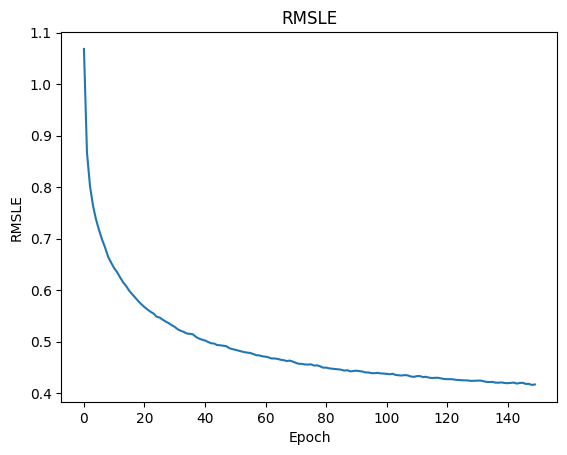

In [42]:
# Plot the RMSLE metric
plt.plot(history.history['rmsle'])
plt.title('RMSLE')
plt.xlabel('Epoch')
plt.ylabel('RMSLE')
plt.show()

In [43]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):

    plt.figure(figsize=(10, 6))
    if type(y) is tuple:
      for y_curr in y:
        plt.plot(x[start:end], y_curr[start:end], format)
    else:
      plt.plot(x[start:end], y[start:end], format)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
      plt.legend(legend)

    plt.title(title)
    plt.grid(True)
    plt.show()

In [44]:
history.history.keys()

dict_keys(['loss', 'rmsle'])

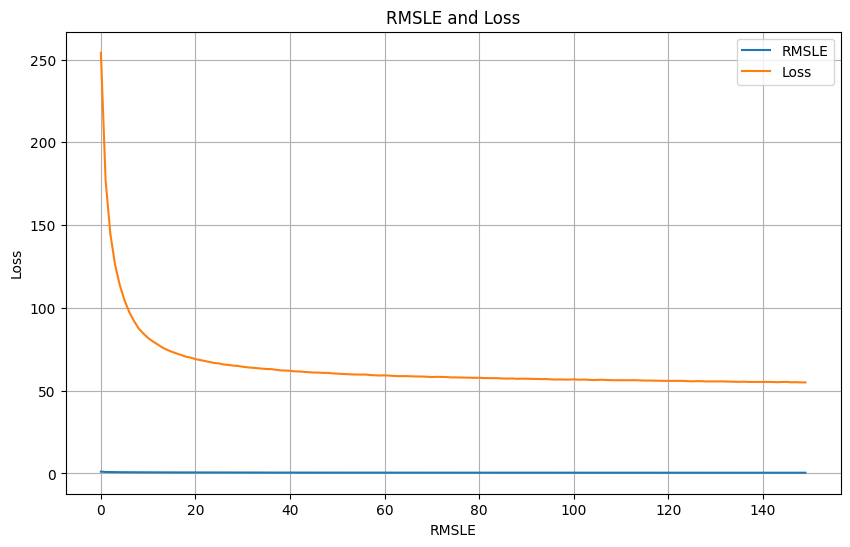

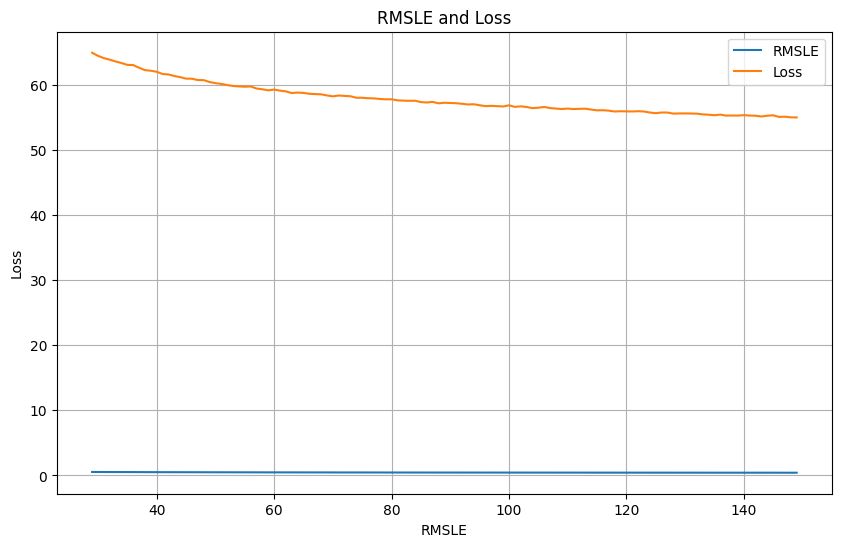

In [45]:
# Get rmsle and loss from history log
rmsle=history.history['rmsle']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot rmsle and loss
plot_series(
    x=epochs, 
    y=(rmsle, loss), 
    title='RMSLE and Loss', 
    xlabel='RMSLE',
    ylabel='Loss',
    legend=['RMSLE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = rmsle[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed rmsle and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='RMSLE and Loss', 
    xlabel='RMSLE',
    ylabel='Loss',
    legend=['RMSLE', 'Loss']
    )

In [46]:
# Make predictions on the validation data
y_pred = model.predict(X_test)

18121/18121 [==============================] - 30s 2ms/step


In [47]:
y_pred

array([[1.6977336e+02],
       [1.9382208e+01],
       [7.9560992e+02],
       ...,
       [1.0716852e+03],
       [6.6340566e-02],
       [9.8981238e+02]], dtype=float32)

In [66]:
y_test

[144.8070068359375,
 30.0,
 1001.406005859375,
 15.0,
 57.0,
 5.0,
 0.0,
 0.0,
 498.0570068359375,
 0.0,
 84.0,
 0.0,
 0.0,
 0.0,
 517.0,
 0.0,
 0.0,
 417.1520080566406,
 1.0,
 3.0,
 518.7630004882812,
 858.0,
 0.0,
 98.63600158691406,
 8.0,
 1964.0,
 206.23300170898438,
 85.39900207519531,
 0.0,
 214.56700134277344,
 1.0,
 1080.0,
 2890.0,
 2712.0,
 4158.93212890625,
 52.0,
 130.0,
 0.0,
 961.3099975585938,
 310.0,
 23.0,
 1.0,
 0.0,
 1.0,
 6.0,
 3041.406005859375,
 75.23300170898438,
 849.2100219726562,
 16.65999984741211,
 0.0,
 1336.447998046875,
 2036.988037109375,
 388.9339904785156,
 27.0,
 0.0,
 0.0,
 0.0,
 279.0,
 179.0,
 79.0,
 1.0,
 140.0,
 393.4179992675781,
 9.0,
 0.0,
 1.0,
 4.0,
 642.0,
 416.656005859375,
 875.0,
 489.0,
 0.0,
 2468.0,
 17.0,
 16.0,
 1847.0,
 0.0,
 15.0,
 1594.0,
 3.0,
 174.0,
 3.0,
 0.0,
 7.0,
 0.0,
 0.0,
 0.0,
 8.0,
 8346.0,
 77.0,
 71.33000183105469,
 10819.556640625,
 52.746002197265625,
 21.0,
 34.0,
 0.0,
 2.0,
 26.0,
 6.0,
 211.56800842285156,
 0.

In [64]:
y_list=y_pred[:,0][0:200].tolist()
y_test = y_test['sales'].tolist()

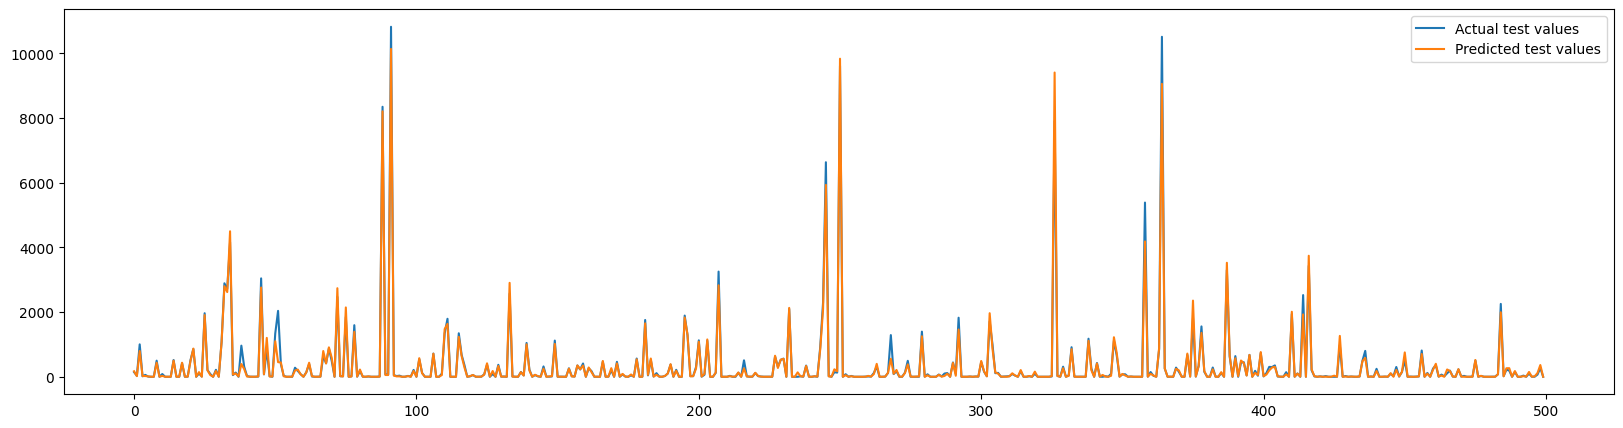

In [68]:
# Plot predicted & actual values
y_list = y_pred.tolist()
sns.reset_defaults()
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(list(y_test[0:500]), label='Actual test values')
ax.plot(list(y_list[0:500]), label='Predicted test values')
plt.legend()
plt.show()

In [53]:
print("mae: ", loss[len(loss)-1])
print("rmsle: ", rmsle[len(rmsle)-1])

mae:  54.98004913330078
rmsle:  0.4167630672454834
